# Test out issues with simple transport on fractures

This notebook asseesses some issues in `extended-tracer-transport`, where no transport occurs at time steps. 

To do this, a really really simple grid will be considered.

Next, a function will be made which solves the Darcy equation in one call.

Then, we have the necessary input to solve / debug the transport problem.

# Simple mesh:

We will use the same wrapper as is used in `extended-tracer-transport` - for consistency.

In [1]:
import porepy as pp
import numpy as np
import scipy.sparse as sps

# Transport implicit discretizations
from porepy.utils.derived_discretizations import implicit_euler as IE_discretizations

In [2]:
def create_domain_2d(domain, mesh_args, fracs_coords, fracs):
    """ Create a fractured 2d domain.
    
    Parameters:
    domain (dict): Dictionary specifying domain boundaries.
        Assumes containing 'xmin', 'xmax', 'ymin', 'ymax'.
    mesh_args (dict): Dictorionary specifying meshing arguments
        Must contain keys:
            'mesh_size_frac': Mesh size in fractures. 
            'mesh_size_min': Minimum mesh size.
        Optional keys:
            'mesh_size_bound': Mesh size at boundaries.
    fracs_coords (np.ndarray 2 x n): Coordinates of fractures.
    fracs (np.ndarray 2 x num_fracs): Endpoints of fractures.
        Defines a mapping to fracs_coords.
            
    """
    network_2d = pp.FractureNetwork2d(fracs_coords, fracs, domain)
    gb = network_2d.mesh(mesh_args)
    return gb



def simple_mesh():
    """ Create a mesh with one fracture and large cells."""
    
    domain = {'xmin': 0, 'xmax': 2, 'ymin': -1, 'ymax': 1}
    p = np.array([[0, 2], [0, 0]])
    e = np.array([[0], [1]])
    mesh_args = {'mesh_size_frac': 1,
                 'mesh_size_bound': 1,}
    gb = create_domain_2d(domain, mesh_args, p, e)
    return gb, domain


# Boundary conditions

In [3]:
def flow_dir(g, b_face_centers, flowdir, domain):
    """ Determine inflow and outflow coordinate mapping.
    
    Parameters
    g (pp.Grid): Grid
    b_face_centers (np.ndarray): Coordinates of boundary face centers
    flowdir (char): Flow direction. One of 'E', 'W', 'N', 'S', 
                                    ('U', 'D' for 3D).
    domain (dict): Domain. Assumes keys 'xmin', 'xmax', 'ymin', 'ymax',
                                    ('zmin', 'zmax' for 3D).
                                    
    """
    tol = 1e-4
    if flowdir in ['W', 'E']:
        axis = 0
        mi, ma = map(domain.get, ['xmin', 'xmax'])
    elif flowdir in ['N', 'S']:
        axis = 1
        mi, ma = map(domain.get, ['ymin', 'ymax'])
    elif flowdir in ['U', 'D']:
        axis = 2
        mi, ma = map(domain.get, ['zmin', 'zmax'])

    # flowdir in ['E', 'N', 'U']
    b_inflow = b_face_centers[axis, :] < mi + tol
    b_outflow = b_face_centers[axis, :] > ma - tol

    if flowdir in ['S', 'W', 'D']:
        b_inflow, b_outflow = b_outflow, b_inflow
    
    return b_inflow, b_outflow


def assign_data(gb, domain, *, flow_param, transport_param, 
                flow_param_edge,  **kwargs):
    """ Assign data for flow and transport problem
    
    Parameters:
    gb (pp.GridBucket): Grid bucket
    domain (dict): Specifies the grid boundaries.
        Assumes it contains the keys: xmin, xmax, ymin, ymax.
    flow_param (str): Keyword reference to flow parameter.
    transport_param (str): Keyword reference to transport parameter.
    flow_param_edge (str): Keyword reference to flow_param_edge parameter.
    
    kwargs (dict): Dictionary of (optional) grid data to be set. 
        Keywords are as follows:
            frac_perm (float, default: 1e3): permeability in fractures
            matrix_perm (float, default: 1): permeability in matrix

    """
    frac_perm = kwargs.get('frac_perm',1e3)
    matrix_perm = kwargs.get('matrix_perm', 1)
    dt = kwargs.get('time_step', 1 / 60)
    t_max = kwargs.get("t_max", 1 / 3)
    flowdir = kwargs.get('flowdir', 'E')
    
    for g, d in gb:
        
        # Permeability
        if g.dim == gb.dim_max():
            kxx = matrix_perm * np.ones(g.num_cells)
        else:
            kxx = frac_perm * np.ones(g.num_cells)
        perm = pp.SecondOrderTensor(kxx)
        
        # BC
        b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
        bc_val = np.zeros(g.num_faces)
        
        #unity = np.ones(g.num_cells)
        #empty = np.empty(0)
        if b_faces.size != 0:
            
            b_face_centers = g.face_centers[:, b_faces]
            b_inflow, b_outflow = flow_dir(g, b_face_centers, 
                                           flowdir, domain)
            
            labels = np.array(['neu'] * b_faces.size)
            labels[np.logical_or(b_inflow, b_outflow)] = "dir"
            bc = pp.BoundaryCondition(g, b_faces, labels)
            
            # Set inflow to 4. (Outflow is 0).
            bc_val[b_faces[b_inflow]] = 4
        
        else:
            bc = pp.BoundaryCondition(g)
        
        # Parameters for flow and transport
        specified_parameters_flow = {
            "bc": bc,
            "bc_values": bc_val,
            'second_order_tensor': perm,
            }
        
        specified_parameters_transport = {
            "bc": bc,
            "bc_values": bc_val,
            'second_order_tensor': perm,
            'time_step': dt,
            't_max': t_max
        }
        
        pp.initialize_default_data(g, d, flow_param, 
                                   specified_parameters_flow)
        pp.initialize_default_data(g, d, transport_param, 
                                   specified_parameters_transport)
        
        # Store the dimension in the dictionary for visualization purposes
        d[pp.STATE] = {"dimension": g.dim * np.ones(g.num_cells)}
    
    for e, d in gb.edges():
        data = {"normal_diffusivity": 2e1}
        d[pp.PARAMETERS] = pp.Parameters(keywords=[flow_param_edge,
                                                   transport_param,
                                                   flow_param],
                                         dictionaries=[data, {}, {}])
        
        d[pp.DISCRETIZATION_MATRICES] = {flow_param_edge: {}}
    
    return gb

# Set up problem


In [4]:
flow_param = 'flow'
transport_param = 'transport'
flow_param_edge = 'flow_param_edge'
gb, domain = simple_mesh()
gb = assign_data(gb, domain, flow_param=flow_param,
                 transport_param=transport_param, 
                 flow_param_edge=flow_param_edge)


In [5]:
#g = gb.grids_of_dimension(2)[0]
#data = gb.node_props(g)
#data[pp.PARAMETERS]['transport']

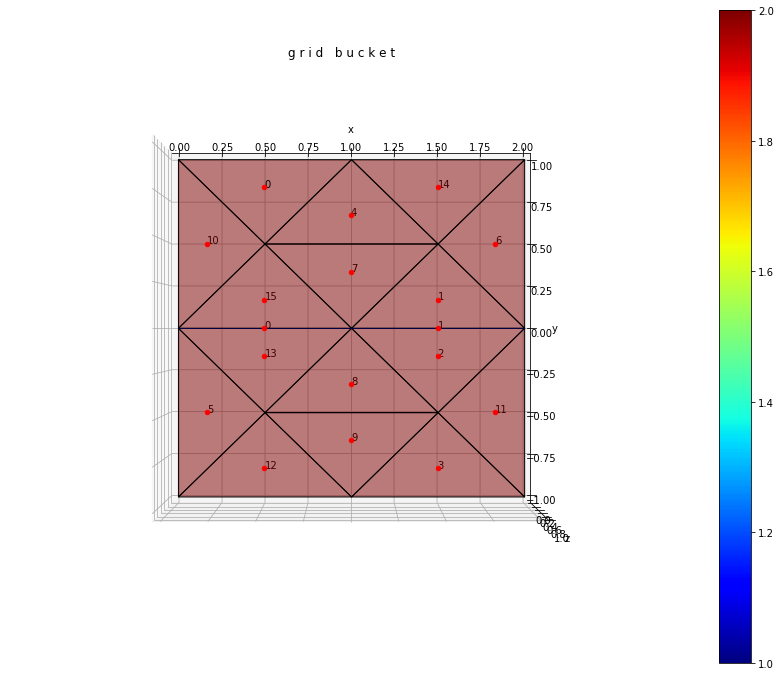

In [6]:
# Plotting
pp.plot_grid(gb, "dimension", info='c', alpha=0.5, figsize=(15,12))

# Solve Darcy's

Next, we want to solve Darcy's equation:
$$ -\nabla \cdot K\nabla p = f$$

In [7]:
def darcy_flow(gb, **kwargs):
    """ Method for solving Darcy's equation
    
    Parameters:
    gb (pp.GridBucket): Grid bucket.
    kwargs: keyword arguments.
        flow_param (str): Name of flow parameter.
        transport_param (str): Name of transport parameter.
        flow_param_edge (str): Name of flow parameter 
                               coupling on mortar grid.
        folder (str): Name of folder to store vtk files in.
        
    """
    
    flow_param = kwargs.get('flow_param', 'flow')
    transport_param = kwargs.get('transport_param', 'transport')
    flow_param_edge = kwargs.get('flow_param_edge', 'flow_param_edge')
    
    # Variable names
    grid_variable = 'pressure'
    mortar_variable = 'mortar_flux'
    
    # Operator names
    diffusion_operator = 'diffusion'
    coupling_operator = 'coupling_operator'
    
    # Discretization methods
    tpfa = pp.Tpfa(flow_param)
    edge_discr = pp.RobinCoupling(flow_param_edge, tpfa, tpfa)
    
    for g, d in gb:
        
        d[pp.PRIMARY_VARIABLES] = {
            grid_variable: {"cells": 1, "faces": 0}
        }
        d[pp.DISCRETIZATION] = {
            grid_variable: {diffusion_operator: tpfa}
        }
        
    for e, d in gb.edges():
        data = {"normal_diffusivity": 2e1}
        g1, g2 = gb.nodes_of_edge(e)
        d[pp.PRIMARY_VARIABLES] = {
            mortar_variable: {'cells': 1}
        }
        
        d[pp.COUPLING_DISCRETIZATION] = {
            coupling_operator: {
                g1: (grid_variable, diffusion_operator),
                g2: (grid_variable, diffusion_operator),
                e: (mortar_variable, edge_discr),
            }
        }
        #d[pp.PARAMETERS] = pp.Parameters(keywords=['flow_param_edge'], 
        #                                 dictionaries=[data])
    
    # Solve
    assembler = pp.Assembler(gb)
    assembler.discretize()
    A, b = assembler.assemble_matrix_rhs()

    pressure = sps.linalg.spsolve(A, b)
    assembler.distribute_variable(pressure)
    
    # Save solution
    folder = kwargs.get('folder', 'simple-transport-with-fracture')
    exporter = pp.Exporter(gb, "flow", folder=folder)
    exporter.write_vtk(grid_variable)
    
    # compute_darcy_flux stores solution in fractures. Need to initialize
    # the corresponding dictionary:
    for _, d in gb.edges():
        if not d[pp.PARAMETERS][transport_param]:
            d[pp.PARAMETERS]
    

    return pressure


In [8]:
for e, d in gb.edges():
    print(d.keys())

dict_keys(['face_cells', 'mortar_grid', 'edge_number', 'parameters', 'discretization_matrices'])


/home/haakon/anaconda3/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


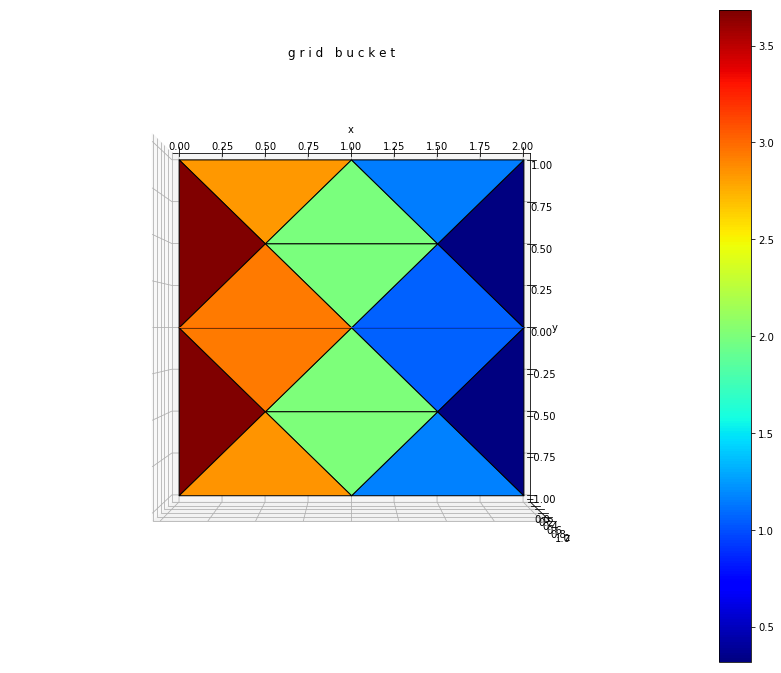

In [9]:
grid_variable = 'pressure'
pressure = darcy_flow(gb)
pp.plot_grid(gb, grid_variable, figsize=(15, 12))

In [10]:
g = gb.grids_of_dimension(2)[0]
data = gb.node_props(g)
data[pp.PARAMETERS]['transport']['darcy_flux']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Transport problem
We aim to solve the transport problem:
$$c\rho \frac{\partial T}{\partial t} + \mathbf{v} \cdot \nabla T - \nabla \cdot (D \nabla T) = f$$

where the physical parameters $c$ (specific heat capacity) and $\rho$ (density) is combined to the parameter `mass_weight`.

In terms of porepy code:
* $c\rho \frac{\partial T}{\partial t}$ is discretized using Upwind.
* $\mathbf{v} \cdot \nabla T$ is discretized using ImplicitMassMatrix
* $- \mathbf{v} \cdot \nabla T$ is discretized using ImplicitTpfa
* $f$ is discretized using (Implicit)ScalarSource ???

Furthermore, the upwind and tpfa terms have edge discretizations of `UpwindCoupling` and `RobinCoupling`, respectively.

Note to `ImplicitScalarSource` --> This method does not (yet) exist. Is it the same setup as ImplicitTpfa?. TRY IT OUT.

In [11]:
class ImplicitTpfa(pp.Tpfa):
    """
    Multiply all contributions by the time step.
    """

    def assemble_matrix_rhs(self, g, data):
        """ Overwrite TPFA method to be consistent with the Biot dt convention.
        """
        a, b = super().assemble_matrix_rhs(g, data)
        dt = data[pp.PARAMETERS][self.keyword]["time_step"]
        a = a * dt
        b = b * dt
        return a, b


def transport(gb, **kwargs):
    """ Solve the transport problem.
    
    Parameters:
    gb (pp.GridBucket): Grid bucket.
    kwargs: keyword arguments.
        transport_param (str): Name of transport parameter.
        grid_variable (str): Name of grid variable.
        mortar_variable (str): Name of mortar variable.
    """
    
    transport_param = kwargs.get('transport_param', 'transport')
    
    grid_variable = kwargs.get('grid_variable', 'tracer')
    mortar_variable = kwargs.get('mortar_variable', 'mortar_tracer')
    
    # Discretization operator identifiers
    advection_term = 'advection'
    #source_term = 'source'
    mass_term = 'mass'
    #diffusion_term = 'diffusion'
    
    advection_coupling_term = 'advection_coupling'
    diffusion_coupling_term = 'diffusion_coupling'
    
    # Discretization objects
    upwind = pp.Upwind(transport_param)
    #source = pp.ScalarSource(transport_param)
    #mass = IE_discretizations.ImplicitMassMatrix(transport_param,
    #                                             grid_variable)
    mass = pp.MassMatrix(transport_param)
    #tpfa = ImplicitTpfa(transport_param)
    
    # Edge discretizations
    edge_upwind = pp.UpwindCoupling(transport_param)
    #edge_tpfa = pp.RobinCoupling(transport_term)
    
    for g, d in gb: 
        d[pp.PRIMARY_VARIABLES] = {
            grid_variable: {'cells': 1, 'faces': 0}
        }
        d[pp.DISCRETIZATION] = {
            grid_variable: {
                advection_term: upwind,
                #source_term: source,
                mass_term: mass,
                #diffusion_term: tpfa,
            }
        }
    
    for e, d in gb.edges():
        g1, g2 = gb.nodes_of_edge(e)
        d[pp.PRIMARY_VARIABLES] = {
            mortar_variable: {'cells': 1}
        }
        d[pp.COUPLING_DISCRETIZATION]: {
            advection_coupling_term: {
                g1: (grid_variable, advection_term),
                g2: (grid_variable, advection_term),
                e: (mortar_variable, edge_upwind),
            },
            #diffusion_coupling_term: {
            #    g1: (grid_variable, diffusion_term),
            #    g2: (grid_variable, diffusion_term),
            #    e: (mortar_variable, edge_tpfa),
            #}
        }
    
    return gb

In [15]:
folder = 'simple-transport-with-fracture'
grid_variable = 'tracer'
mortar_variable = 'mortar_tracer'

pp.fvutils.compute_darcy_flux(gb, keyword_store=transport_param,
                                  lam_name='mortar_flux')

# discretize and assemble system
assembler2 = pp.Assembler(gb)#, active_variables=[grid_variable, 
                             #                  mortar_variable])
#assembler._identify_dofs()

# Initial condition
tracer = np.zeros(gb.num_cells())
assembler2.distribute_variable(
    tracer, variable_names=[grid_variable, mortar_variable]
)

#data[pp.PARAMETERS]

In [16]:

gb = transport(gb,
               grid_variable=grid_variable,
               mortar_variable=mortar_variable)


assembler2.discretize()

A, b = assembler2.assemble_matrix_rhs()

# Exporter
exporter = pp.Exporter(gb, name="tracer", folder=folder)
export_fields = ["tracer"]

KeyError: ((Grid with history TriangleGrid, Compute geometry
Number of cells 16
Number of faces 30
Number of nodes 16
Dimension 2, Grid with history TensorGrid, Compute geometry
Number of cells 2
Number of faces 3
Number of nodes 3
Dimension 1), 'mortar_flux')

In [17]:
%debug

> /home/haakon/porepy/src/porepy/numerics/mixed_dim/assembler.py(401)_operate_on_gb()
    399 
    400                 # Global block index associated with this edge variable
--> 401                 ei = self.block_dof[(e, edge_key)]
    402 
    403                 # Get variable name and block index of the master variable.

ipdb> self.block_dof
{(Grid with history TriangleGrid, Compute geometry
Number of cells 16
Number of faces 30
Number of nodes 16
Dimension 2, 'tracer'): 0, (Grid with history TensorGrid, Compute geometry
Number of cells 2
Number of faces 3
Number of nodes 3
Dimension 1, 'tracer'): 1, ((Grid with history TriangleGrid, Compute geometry
Number of cells 16
Number of faces 30
Number of nodes 16
Dimension 2, Grid with history TensorGrid, Compute geometry
Number of cells 2
Number of faces 3
Number of nodes 3
Dimension 1), 'mortar_tracer'): 2}
ipdb> exit


In [ ]:
for g, d in gb:
    print(assembler.block_dof)

In [ ]:
x = sps.linalg.spsolve(A,b)

In [ ]:
x

In [ ]:
b